In [1]:
# The notebook "seeingModel_demo" demonstrates a bit more in-depth usage and modifications for the seeing model. 
# This notebook is intended to show the simple recommended usage, in the most straightforward way.

sims_SeeingModel contains two main classes: SeeingData and SeeingModel.
The SeeingData class is simply intended to read a seeing database containing IQ measurements from zenith at 500nm (essentially the processed output from the DIMM) and feed it to the scheduler: this is simulating the data available in the EFD. 
The SeeingModel class calculates the expected FWHM in an image, based on the IQ @ zenith/500nm combined with the airmass of the observation and the filter in use. The SeeingModel is our "model" of how the atmosphere and telescope will modify the base atmospheric conditions, providing an expected delivered FWHM (both FWHM_geom and FWHM_eff).

While the LSST PSF is best described with a von Karman profile, there are some simpler approximate parametrizations which are generated by the SeeingModel. These are the FWHM_eff and the FWHM_geom. 

FWHM_geom represents the approximate physical 'size' of the PSF, if it were represented by a double-peaked Gaussian with this FWHM. 

FWHM_eff represents the FWHM of a single-peaked Gaussian PSF which would generate the same Signal To Noise as the full von Karman profile. 

For SNR purposes, use the FWHM_eff and assume the PSF is a single-peaked Gaussian. For "size of the PSF" purposes such as calculating trailing losses for moving objects, use the FWHM_geom value. 

* SeeingData accepts a time, and outputs a von Karman "FWHM" at 500 nm at zenith value, appropriate for input into the SeeingModel. 
* SeeingModel accepts the FWHM @500nm/zenith and an airmass (or airmass array), and outputs FWHM_eff and FWHM_geom in each filter at the specified airmass(es). 

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


from lsst.utils import getPackageDir

from astropy.time import Time, TimeDelta
from lsst.sims.seeingModel import SeeingData, SeeingModel

Set up SeeingData and connect to the seeing database.

The information in the seeing database is expected to be in a table called `Seeing`, with columns `s_date` and `seeing`. 

`s_date` is the time in seconds, of the corresponding `seeing` (the FWHM @ 500nm at zenith, in arcseconds). 

`s_date` = 0 is assumed to be Jan 1 Midnight of the year of the survey start.  You can offset into the database (so that s_date=0 is Jan 1 of a different year or even a different month) by setting offset_year to be non-zero. 

If a FWHM_500 is requested from SeeingData at a time which is not within the range of `s_date` values, the time will be wrapped to fall within `s_date` (i.e. the seeing database will repeat). 

The defaults for SeeingData are reasonable, but are demonstrated here for clarity.

In [3]:
survey_start = Time('2022-10-20T18:00', format='isot')

In [4]:
seeing_db = os.path.join(getPackageDir('SIMS_SEEINGMODEL'), 'data', 'simsee_pachon_58777_13.db')

In [5]:
seeingData = SeeingData(survey_start, seeing_db=seeing_db, offset_year=1)
seeingData.read_data()

In [6]:
seeingData.config_info()

{'Start time for db': <Time object: scale='tai' format='isot' value=2023-01-01T00:00:00.000>,
 'Seeing database': '/Users/lynnej/lsstRepos/sims_seeingModel/data/simsee_pachon_58777_13.db'}

Set up SeeingModel. 

This can be done using the defaults, using a SeeingModelConfig (and potentially modifying the config), or by using a dictionary (this is intended for YAML setup). 

In [7]:
seeingModel = SeeingModel(config=None)

In [8]:
seeingModel.config_info()

OrderedDict([('SeeingModel_version', 'unknown'),
             ('SeeingModel_sha', '9c227f867ba771bd4c66fa36de37e3bafb93a1a9 *'),
             ('telescope_seeing', 0.25),
             ('optical_design_seeing', 0.08),
             ('camera_seeing', 0.3),
             ('raw_seeing_wavelength', 500.0),
             ('filter_list', ['u', 'g', 'r', 'i', 'z', 'y']),
             ('filter_effwavelens',
              [368.48, 480.2, 623.12, 754.17, 869.05, 973.64]),
             ('throughputs_version', '1.5'),
             ('efd_columns', ['FWHM_500']),
             ('efd_delta_time', 0.0),
             ('target_columns', ['airmass'])])

Then the seeing data and seeing model can be used together as so: 

In [9]:
# When is the observation? (or what time is it now, when we're choosing an observation)
visit_time = Time('2020-10-20T19:00', format='isot')

In [10]:
# Get the raw data "from the EFD" (or really, from the SeeingData)
efdData = {}
efdData['FWHM_500'] = seeingData(visit_time)

In [11]:
# Set up the target information -- Where on the sky do we want to calculate the expected seeing? 
# For scheduler use, this is usually over the entire visible sky in a healpix grid.
# See the notebook 'SeeingModel_Demo' for an example of setting up a healpix grid and then calculating
# altitude/airmass for each point. 
# But for now, let's say we just have an array of airmass values that we arrived at somehow.
targetInfo = {}
targetInfo['airmass'] = np.arange(1.0, 3.0, 0.05)

In [12]:
# Now calculate the expected seeing information over the sky, using the SeeingModel.
# It returns a dictionary of 'fwhmEff' and 'fwhmGeom' values at each target (airmass), in each filter.
seeingInfo = seeingModel(efdData, targetInfo)

In [13]:
seeingInfo.keys()

dict_keys(['fwhmEff', 'fwhmGeom'])

In [14]:
seeingInfo['fwhmEff']

array([[0.96471182, 0.99337032, 1.02148786, 1.04909859, 1.07623311,
        1.10291897, 1.12918113, 1.15504222, 1.18052291, 1.20564209,
        1.23041709, 1.25486388, 1.27899719, 1.30283065, 1.32637691,
        1.34964773, 1.37265407, 1.39540616, 1.41791357, 1.44018528,
        1.46222969, 1.48405473, 1.50566785, 1.52707608, 1.54828608,
        1.5693041 , 1.59013612, 1.61078775, 1.63126435, 1.65157101,
        1.67171256, 1.69169361, 1.71151854, 1.73119155, 1.75071663,
        1.77009761, 1.78933814, 1.80844171, 1.82741169, 1.84625128],
       [0.90849123, 0.93547959, 0.96195853, 0.98796018, 1.01351338,
        1.03864407, 1.06337574, 1.08772973, 1.11172548, 1.13538078,
        1.15871197, 1.18173407, 1.20446096, 1.22690547, 1.24907953,
        1.27099419, 1.29265979, 1.31408596, 1.3352817 , 1.35625547,
        1.3770152 , 1.39756834, 1.41792191, 1.43808254, 1.45805647,
        1.47784963, 1.49746761, 1.51691573, 1.53619901, 1.55532226,
        1.57429002, 1.59310663, 1.61177623, 1.6

Text(0.5, 1.0, 'Expected delivered FWHMeff for FWHM_500 @ zenith=0.65')

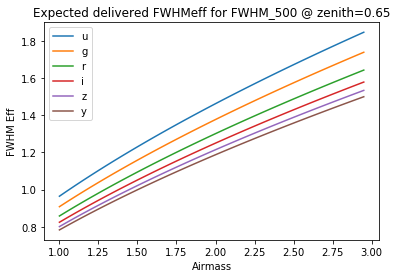

In [15]:
# Let's make a plot, to further show what those data points were.
filterlist = seeingModel.filter_list
airmass = targetInfo['airmass']
for i, f in enumerate(filterlist):
    fwhm_eff = seeingInfo['fwhmEff'][i]
    plt.plot(airmass, fwhm_eff, label=f)
plt.legend(loc='upper left')
plt.xlabel('Airmass')
plt.ylabel('FWHM Eff')
plt.title('Expected delivered FWHMeff for FWHM_500 @ zenith=%.2f' % (efdData['FWHM_500']))